# Empirical data analysis for De et al 2025
# Using Neural Posterior Estimation (NPE) with a Wright-Fisher (WF) model

In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import pickle
from wf import WF
import matplotlib
import seaborn as sns
from seaborn import pairplot
from collective_posterior_de import CollectivePosterior
from matplotlib.lines import Line2D

import warnings
warnings.simplefilter('ignore', Warning)

# for making larger graphs
def change_font(fontsize):
    matplotlib.rcParams['xtick.labelsize'] = fontsize
    matplotlib.rcParams['ytick.labelsize'] = fontsize
    matplotlib.rcParams['font.size'] = fontsize

In [2]:
# load posteriors, prior, data, etc.
posterior = pickle.load(open('results/posterior_de_3p_10000_noisy.pkl','rb'))
prior = posterior.prior
data = pd.read_csv('empirical_data/clean_data_exp_2.csv')

# Filter contaminated replicate
clean_data = data.drop(data[data['Strain']=='DGY2751_1'].index)

# Prep
num_lines = len(data['Line'].unique())
num_strains_max = 4 # max strains per line
generation = np.array(data[data['Strain'] == 'DGY1886_1']['Generation'])

# Match color palettes
colors_mep = ['peru', 'orange', 'brown', 'orangered', 'sienna']
colors_gap = ['royalblue', 'limegreen', 'green', 'darkturquoise', 'steelblue']
color_g = 'steelblue'
color_m = 'sienna'
# Match strain names
line_mapping = {'DGY1886': 'G_4', 'DGY2748': 'GM_12', 'DGY2750': 'GM_13', 'DGY2751':'GM_14', 'DGY2755':'GM_15'}

In [3]:
# posterior predictive checks - plot posterior samples against empirical data
def plot_ppc(ax, posterior, strain, df, generation=generation, color='k', target = 'Multicopy_mCitrine ', n_samples=100):    
    # load x and evaluate posterior
    x_0 = df[df['Strain']==strain][['Generation', target]]
    samples = posterior.set_default_x(np.array(x_0[target])).sample((n_samples,)) # sample from posterior of strain
    
    # plot WF(posterior samples)
    for i in range(len(samples)):
        ax.plot(generation, WF(samples[i,0], samples[i,1], samples[i,2], generation), color=color, lw=40/n_samples)
        
    # plot empirical data
    y = x_0[target]
    ax.plot(generation, y, color=color, ls = '-', lw=4.5)
    ax.scatter(generation, y, color=color, s=60)
    
    return samples[posterior.log_prob(samples).argmax()] # quick MAP approximation

# collective posterior predictive checks
def plot_collective_ppc(ax, posterior, df, line, epsilon, color, colors, n_samples=1000, target = 'Multicopy_mCitrine '):
    # load X - size = (N_reps, generations)
    X = df[df['Line'] == line][target]
    Xs = torch.from_numpy(np.array(X).reshape(len(X)//len(generation),len(generation)))
    
    # Initialize a Collective Posterior and sample from it
    cp = CollectivePosterior(posterior.prior,Xs,posterior, epsilon=epsilon)
    cp.get_log_C()
    samples = cp.rejection_sample(n_samples)
    
    # Plotting
    # Predictions
    
    for i in range(len(Xs)):
        ax.plot(generation,Xs[i], color=colors[i], ls='-', lw=4.5)
        ax.scatter(generation,Xs[i], color=color, s=60)
    # Empirical data (with matching colors)
    for j in range(n_samples):
        ax.plot(generation, WF(samples[j,0],samples[j,1], samples[j,2], generation), color=color, lw=40/n_samples, ls='-')
    # ax.set_facecolor('whitesmoke')
    ax.set_yticklabels([int(100*float(g)) for g in ax.get_yticks()])
    return
    # return cp.get_map() # collective MAP

Rejection Sampling: 965it [00:00, 5870.46it/s]             
Rejection Sampling: 613it [00:00, 3752.65it/s]             
Rejection Sampling: 309it [00:00, 1801.50it/s]             
Rejection Sampling: 1955it [00:00, 18267.87it/s]           
Rejection Sampling: 678it [00:00, 6587.01it/s]             
Rejection Sampling: 177it [00:00, 1307.94it/s]             
Rejection Sampling: 338it [00:00, 2565.30it/s]             
Rejection Sampling: 1076it [00:00, 6622.83it/s]            
Rejection Sampling: 287it [00:00, 1403.65it/s]             


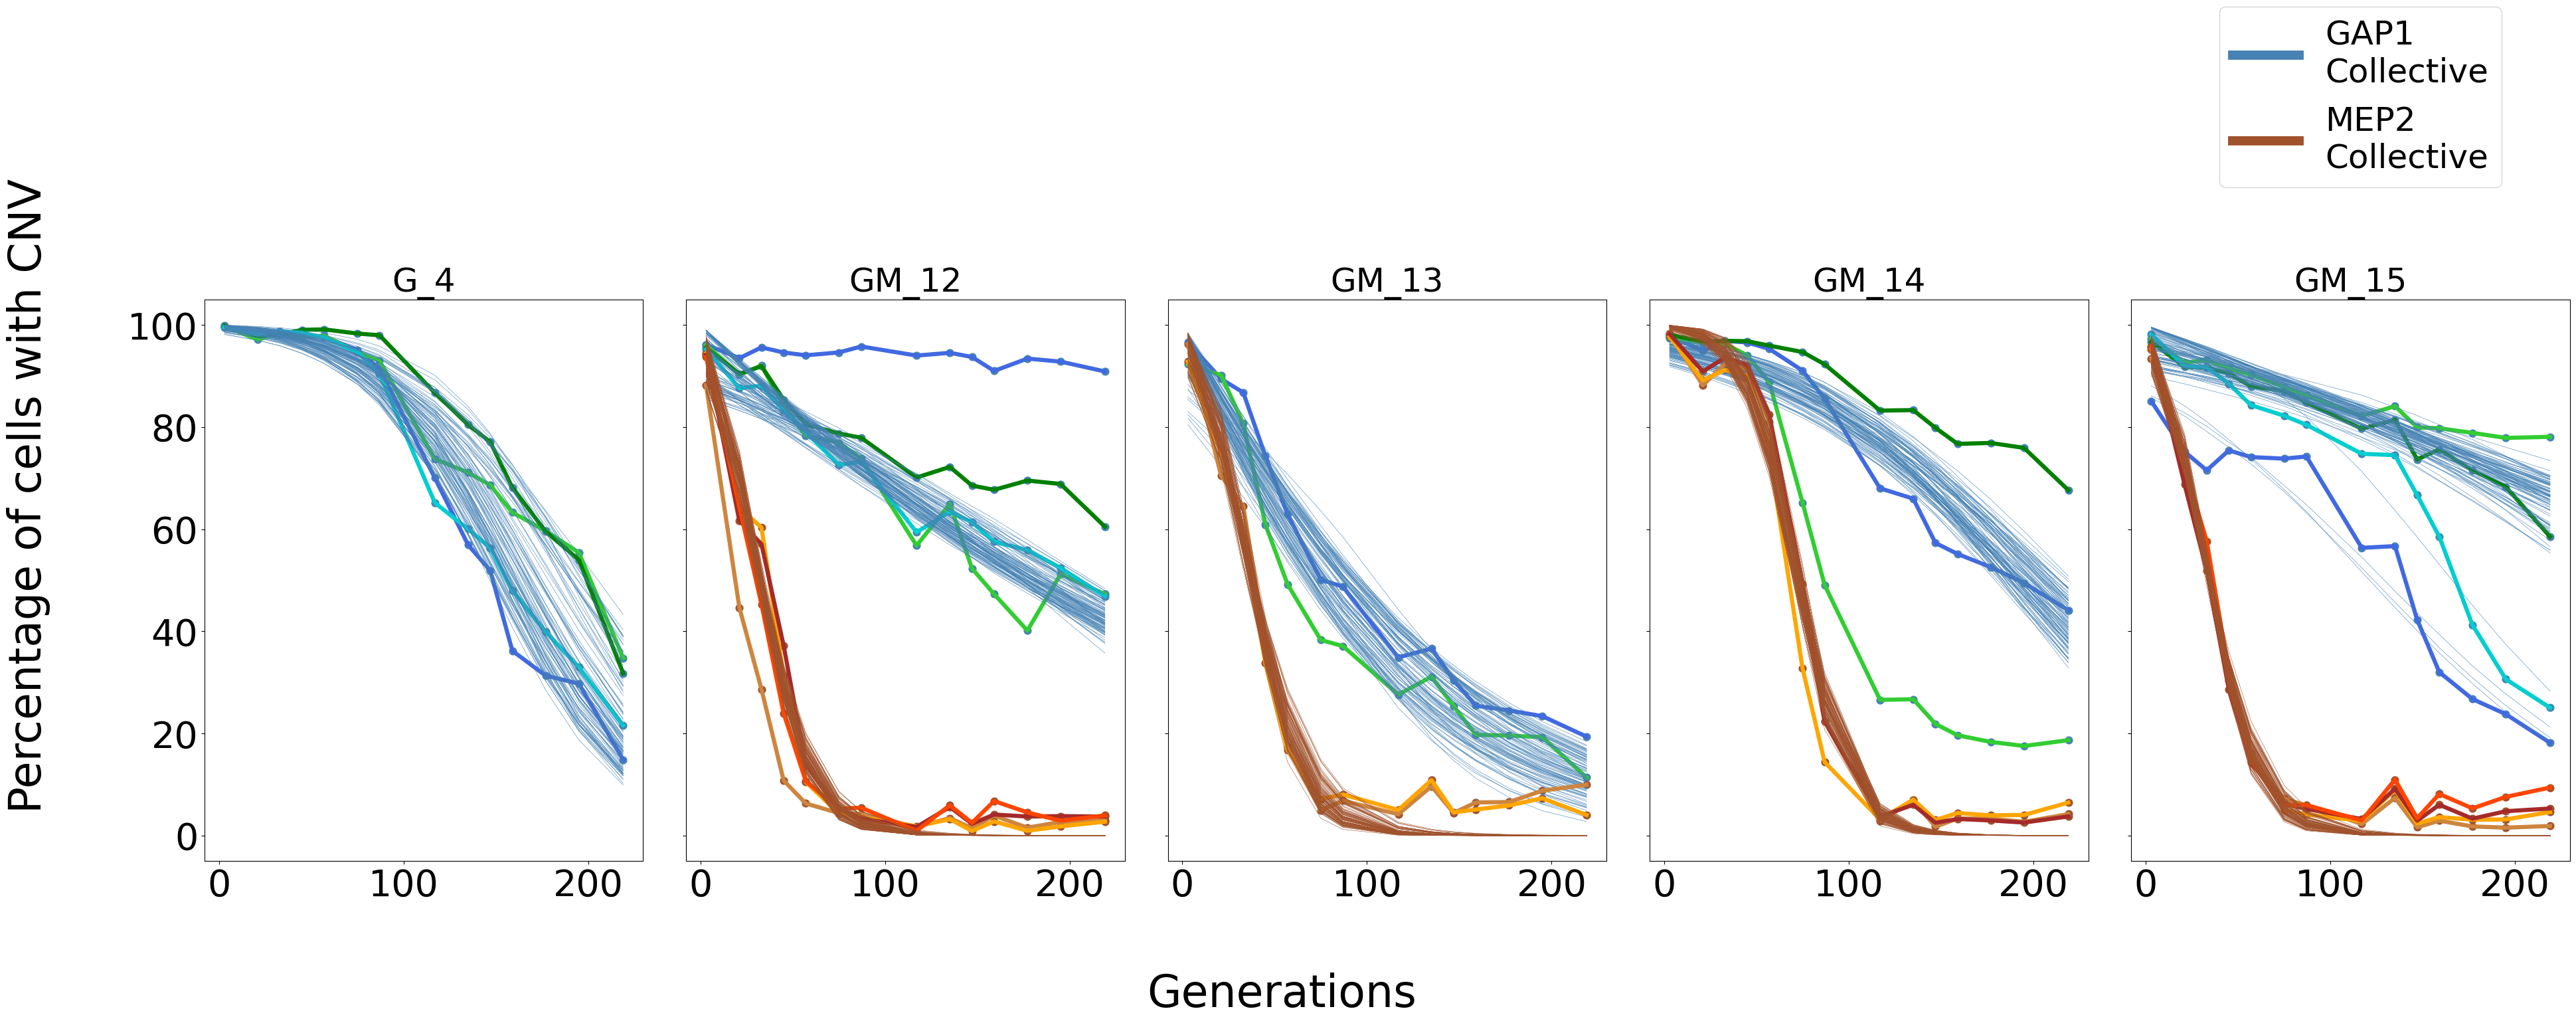

In [4]:
# Large fonts for the paper
change_font(40)

# create a single figure for all lines - X is generation, Y is cnv proportion
lines = clean_data['Line'].unique()
fig, ax = plt.subplots(1,len(lines), figsize=(40,16), sharex=True, sharey=True, tight_layout=True)
fig.supxlabel('Generations')
fig.supylabel('Percentage of cells with CNV\n')

epsilons = [-30,-30,-30,-60,-30] # for one strain ε = e^-30 lead to data overfittting

# For saving total fitness cost of strains
c_est_g = []
est_g = []
c_est_m = []
est_m = []

# Construct figure
# ax[i,j] will show predictive checks for the i'th line's j'th replicate
for i in range(len(lines)):
    dd = clean_data[clean_data['Line']==lines[i]] # data for line i
    local_strains = dd['Strain'].unique() # strains of line i
    # Save parameters
    c_est_g.append(plot_collective_ppc(ax=ax[i], posterior=posterior, df=dd, line=lines[i], epsilon=epsilons[i], n_samples=100, color=color_g, colors=colors_gap,\
                                       target='Multicopy_mCitrine '))
    if i!=0:
        c_est_m.append(plot_collective_ppc(ax=ax[i], posterior=posterior, df=dd, line=lines[i], epsilon=epsilons[i], n_samples=100, color=color_m, colors=colors_mep,\
                                           target='Multicopy_mCherry'))
    ax[i].set_title(line_mapping[lines[i]], fontsize=36, loc='center')
    # for j in range(len(local_strains)):
    #     # ax[i,j+1].set_title(local_strains[j], fontsize=30)
    #     est_g.append(plot_ppc(ax[i,j+1], posterior, local_strains[j], dd, generation=generation, color=colors_gap[j], target = 'Multicopy_mCitrine '))
    #     if i!=0:
    #         est_m.append(plot_ppc(ax[i,j+1], posterior, local_strains[j], dd, generation=generation, color=colors_mep[j], target = 'Multicopy_mCherry'))
    # if len(local_strains) < num_strains_max:
    #     for k in range(len(local_strains)+1,num_strains_max+1):
    #         ax[i,k].set_axis_off()


            


# Legend
legend_elements = []
# for i in range(len(colors_gap)-1):
#     legend_elements.append(Line2D([0], [0], color=colors_gap[i], lw=8, label='GAP1' if i==2 else ''))
legend_elements.append(Line2D([0], [0], color=colors_gap[-1], lw=10, label='GAP1\nCollective'))
# for j in range(len(colors_mep)-1):
#     legend_elements.append(Line2D([0], [0], color=colors_mep[j], lw=8, label='MEP2' if j==2 else ''))
legend_elements.append(Line2D([0], [0], color=colors_mep[-1], lw=10, label='MEP2\nCollective'))   

ax[4].legend(ncol=1, handles=legend_elements, fontsize=36, loc = (0.2,1.2))
fig.savefig('panel B.pdf', dpi=600)

Rejection Sampling: 1049it [00:00, 6450.51it/s]            


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Rejection Sampling: 616it [00:00, 2948.65it/s]             
Rejection Sampling: 276it [00:00, 1677.93it/s]             


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Rejection Sampling: 1906it [00:00, 18627.93it/s]           
Rejection Sampling: 644it [00:00, 5608.83it/s]             


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Rejection Sampling: 179it [00:00, 1233.34it/s]             
Rejection Sampling: 295it [00:00, 1932.92it/s]             


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Rejection Sampling: 1039it [00:00, 6271.59it/s]            
Rejection Sampling: 265it [00:00, 1613.44it/s]             


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

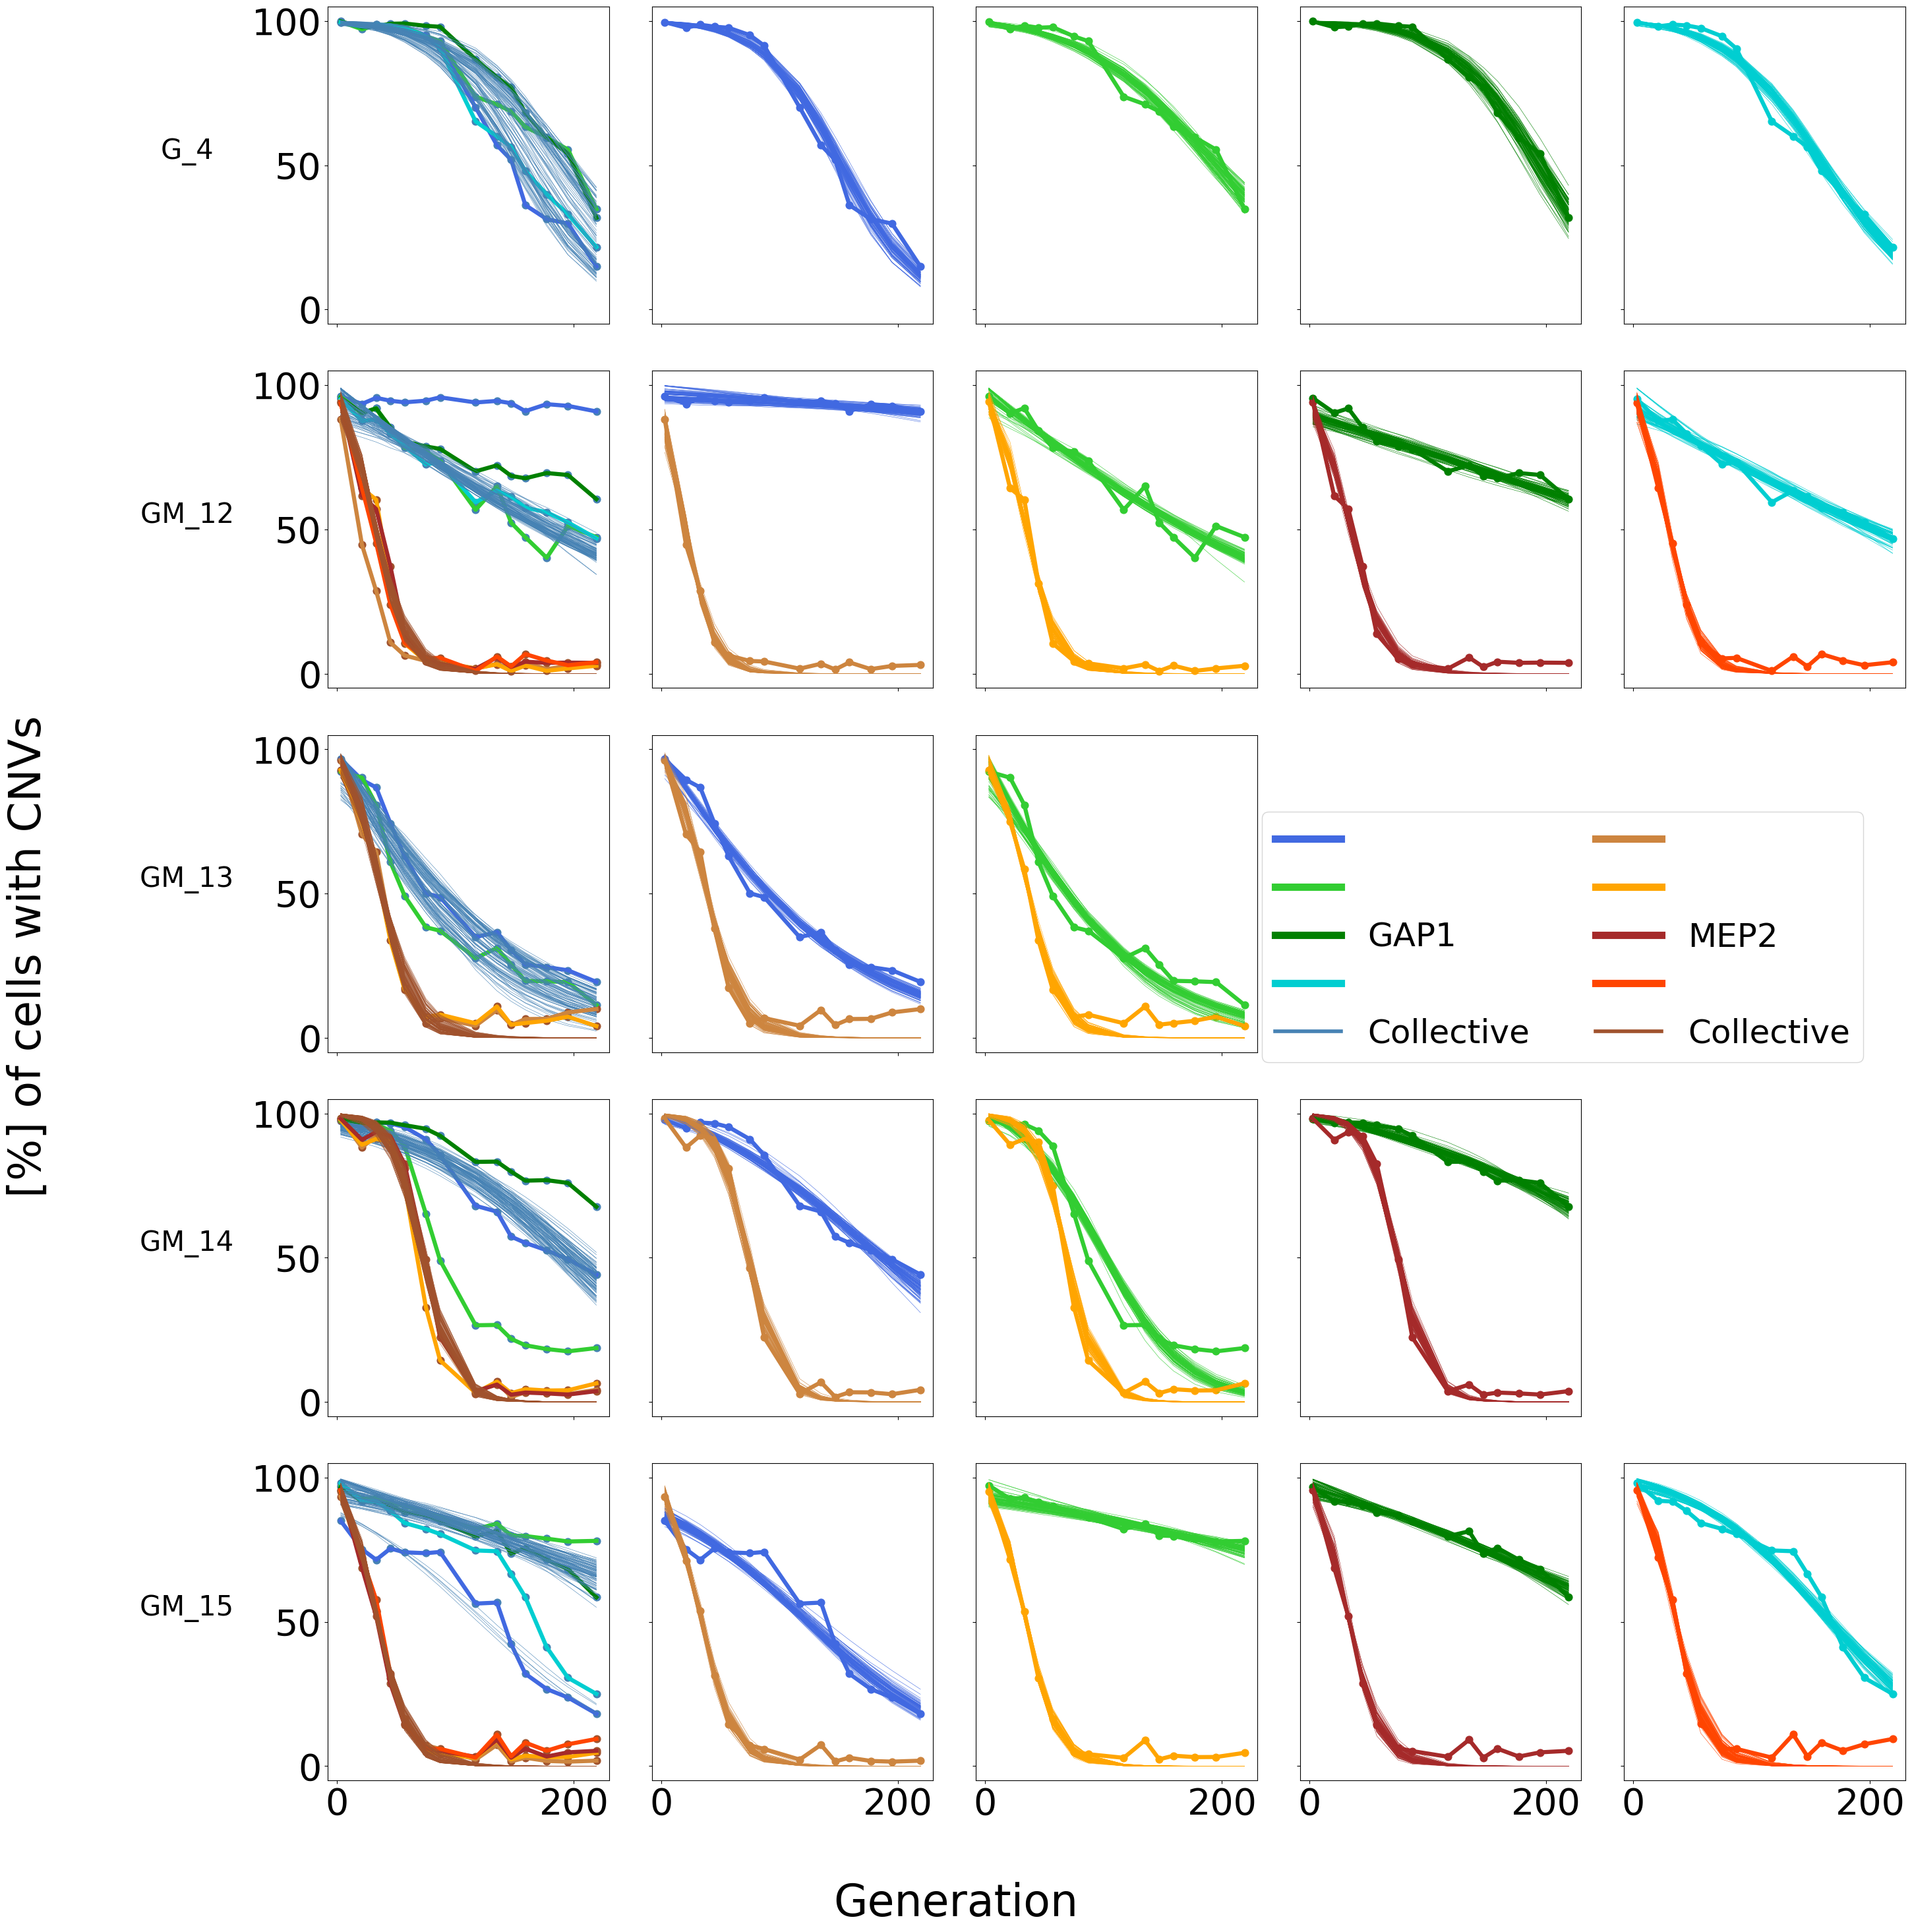

In [5]:
# Large fonts for the paper
change_font(40)

# create a single figure for all lines - X is generation, Y is cnv proportion
lines = clean_data['Line'].unique()
fig, ax = plt.subplots(len(lines), num_strains_max+1, figsize=(30,30), sharex=True, sharey=True, tight_layout=True)
fig.supxlabel('Generation')
fig.supylabel('[%] of cells with CNVs\n')

epsilons = [-30,-30,-30,-60,-30] # for one strain ε = e^-30 lead to data overfittting

# For saving total fitness cost of strains
c_est_g = []
est_g = []
c_est_m = []
est_m = []

# Construct figure
# ax[i,j] will show predictive checks for the i'th line's j'th replicate
for i in range(len(lines)):
    dd = clean_data[clean_data['Line']==lines[i]] # data for line i
    local_strains = dd['Strain'].unique() # strains of line i
    # Save parameters
    c_est_g.append(plot_collective_ppc(ax=ax[i,0], posterior=posterior, df=dd, line=lines[i], epsilon=epsilons[i], n_samples=100, color=color_g, colors=colors_gap,\
                                       target='Multicopy_mCitrine '))
    if i!=0:
        c_est_m.append(plot_collective_ppc(ax=ax[i,0], posterior=posterior, df=dd, line=lines[i], epsilon=epsilons[i], n_samples=100, color=color_m, colors=colors_mep,\
                                           target='Multicopy_mCherry'))
    ax[i,0].set_ylabel(line_mapping[lines[i]]+14*' ', fontsize=30, loc='center', rotation='horizontal')
    for j in range(len(local_strains)):
        # ax[i,j+1].set_title(local_strains[j], fontsize=30)
        est_g.append(plot_ppc(ax[i,j+1], posterior, local_strains[j], dd, generation=generation, color=colors_gap[j], target = 'Multicopy_mCitrine '))
        if i!=0:
            est_m.append(plot_ppc(ax[i,j+1], posterior, local_strains[j], dd, generation=generation, color=colors_mep[j], target = 'Multicopy_mCherry'))
    if len(local_strains) < num_strains_max:
        for k in range(len(local_strains)+1,num_strains_max+1):
            ax[i,k].set_axis_off()


            


# Legend
legend_elements = []
for i in range(len(colors_gap)-1):
    legend_elements.append(Line2D([0], [0], color=colors_gap[i], lw=8, label='GAP1' if i==2 else ''))
legend_elements.append(Line2D([0], [0], color=colors_gap[-1], lw=4, label='Collective'))
for j in range(len(colors_mep)-1):
    legend_elements.append(Line2D([0], [0], color=colors_mep[j], lw=8, label='MEP2' if j==2 else ''))
legend_elements.append(Line2D([0], [0], color=colors_mep[-1], lw=4, label='Collective'))   

fig.legend(ncol=2, handles=legend_elements, fontsize=36, loc=(0.66,0.45))

fig.savefig('S5.pdf', dpi=600)

DGY1886


Sampling: 100%|██████████| 200/200 [00:00<00:00, 1158.07it/s]


tensor(0.9749) tensor(0.9705)
tensor(0.9729)
DGY2748


Sampling: 100%|██████████| 200/200 [00:00<00:00, 1257.77it/s]


tensor(0.9918) tensor(0.9882)
tensor(0.9900)
DGY2748


Sampling: 100%|██████████| 200/200 [00:00<00:00, 1214.38it/s]


tensor(0.9551) tensor(0.9325)
tensor(0.9450)
DGY2750


Sampling: 100%|██████████| 200/200 [00:00<00:00, 1999.11it/s]


tensor(0.9847) tensor(0.9767)
tensor(0.9807)
DGY2750


Sampling: 100%|██████████| 200/200 [00:00<00:00, 2006.85it/s]


tensor(0.9622) tensor(0.9329)
tensor(0.9518)
DGY2751


Sampling: 100%|██████████| 200/200 [00:00<00:00, 1245.11it/s]


tensor(0.9865) tensor(0.9826)
tensor(0.9849)
DGY2751


Sampling: 100%|██████████| 200/200 [00:00<00:00, 1210.33it/s]


tensor(0.9302) tensor(0.9169)
tensor(0.9224)
DGY2755


Sampling: 100%|██████████| 200/200 [00:00<00:00, 1223.89it/s]


tensor(0.9936) tensor(0.9890)
tensor(0.9913)
DGY2755


Sampling: 100%|██████████| 200/200 [00:00<00:00, 1220.46it/s]


tensor(0.9370) tensor(0.9213)
tensor(0.9278)


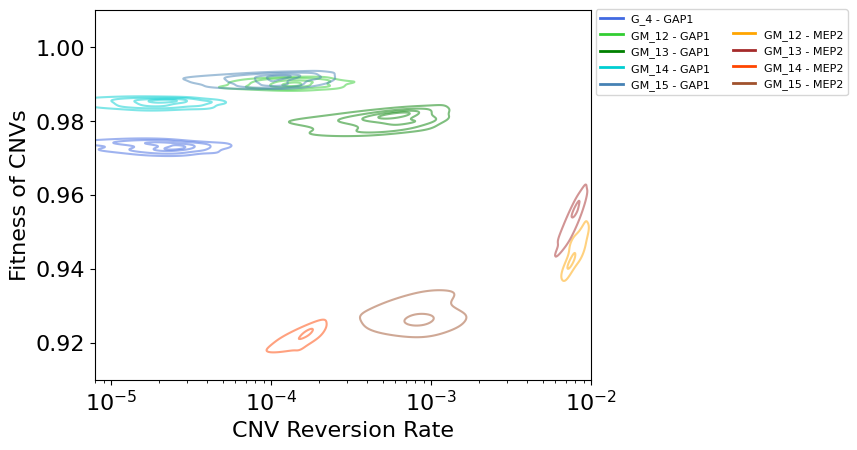

In [12]:
# HDRs

from seaborn import kdeplot

def get_collective_samples(line, target, epsilon):
    print(line)
    X = data[data['Line'] == line][target]
    Xs = torch.from_numpy(np.array(X).reshape(len(X)//len(generation),len(generation)))
    cp = CollectivePosterior(posterior.prior,Xs,posterior, epsilon=epsilon,n_eval=100_000)
    cp.get_log_C()
    samples = cp.sample(200, method='unimodal')
    print(1/(1+(10**samples.quantile(0.025, 0)[0])), 1/(1+(10**samples.quantile(0.975,0)[0])))
    print(1/(1+(10**samples.quantile(0.5, 0)[0])))
    return samples[:,:2]

change_font(16)
lines = data['Line'].unique()
epsilons = [-30,-30,-30,-60,-30]
fig, ax = plt.subplots()
sg, δg, sm, δm = [], [], [], []
for i in range(len(lines)):
    dd = data[data['Line']==lines[i]] # data for line i
    local_strains = dd['Strain'].unique() # strains of line i
    samples = get_collective_samples(lines[i], 'Multicopy_mCitrine ', epsilons[i])
    kdeplot(x=10**samples[:,1], y=1/(1+10**samples[:,0]), color=colors_gap[i],levels=[0.25, 0.5, 0.8, 0.95], alpha=0.5, label=line_mapping[lines[i]]+' - GAP1')
    # ax.scatter(10**δ_g, 1/(1+10**s_g)-1, color=colors_gap[i], label=line_mapping[lines[i]]+' - GAP1', s=70)
    
    if i!=0:
        samples = get_collective_samples(lines[i], 'Multicopy_mCherry', epsilons[i])
        kdeplot(x=10**samples[:,1], y=1/(1+10**samples[:,0]), color=colors_mep[i],levels=[0.5, 0.95], alpha=0.5, label=line_mapping[lines[i]]+' - MEP2')
        
ax.set_xlabel('CNV Reversion Rate')
ax.set_ylabel('Fitness of CNVs')
ax.set_xlim(10**-5.1, 10**-2)
ax.set_ylim(0.91, 1.01)
ax.set_xscale('log')

legend_elements = []
for i in range(len(colors_gap)):
    legend_elements.append(Line2D([0], [0], color=colors_gap[i], lw=2, label=line_mapping[lines[i]]+' - GAP1'))
for j in range(len(colors_mep)):
    if j==0:
        legend_elements.append(Line2D([0],[0], label='', color='white'))
    else:
        legend_elements.append(Line2D([0], [0], color=colors_mep[j], lw=2, label=line_mapping[lines[j]]+' - MEP2'))

ax.legend(ncol=2, handles=legend_elements, fontsize=8, loc=(1.01,0.77))

fig.savefig('S4.pdf', dpi=600)

Rejection Sampling: 1039it [00:00, 6428.80it/s]            


tensor(-1.5872) tensor(-3.7404) tensor(-3.3051)


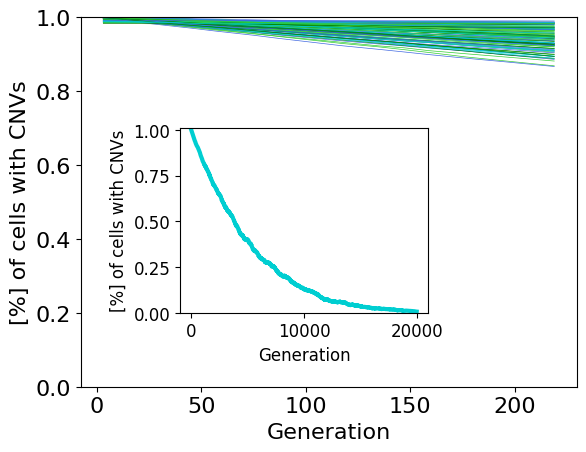

In [9]:
# Simulating GAP1 CNV reversion without selection (s = 10^-10) for G_

# get data and prep
change_font(16)
line = 'DGY1886'
target = 'Multicopy_mCitrine '
X = data[data['Line'] == line][target]
fig, ax = plt.subplots()
# parameter inference
Xs = torch.from_numpy(np.array(X).reshape(len(X)//len(generation),len(generation)))
cp = CollectivePosterior(posterior.prior,Xs,posterior, epsilon=-30)
cp.get_log_C()
samples = cp.sample(100)
x = generation

# simulate plot
for i in range(len(samples)):
    s,m,p = samples[i]
    y = WF(-10,m,p, generation)
    ax.plot(x,y, color=colors_gap[i%4], lw=0.5)

ax.set_ylim(0,1)
ax.set_xlabel('Generation')
ax.set_ylabel('[%] of cells with CNVs')

change_font(12)
ix = ax.inset_axes((0.2,0.2,0.5,0.5))
# single long simulation
s,m,p = samples.mean(0)
g = np.array([i for i in range(0,20_001,5)])
print(s,m,p)
y = WF(-10.,m,p, g)
ix.plot(g,y, color='darkturquoise', lw=3)
ix.set_ylim(0,1.01)
ix.set_xlabel('Generation')
ix.set_ylabel('[%] of cells with CNVs')

fig.savefig('S8.pdf', dpi=600)

In [22]:
# Collective parameter estimates
c_df = pd.read_csv('results/collective fitness estimates.csv', index_col=0)
c = pd.DataFrame(index = c_df.index, columns = ['$s_G$', '$δ_G$', '$s_M$', '$δ_M$'])
c.iloc[:,0] = sg
c.iloc[:,1] = δg
c.iloc[1:,2] = sm
c.iloc[1:,3] = δm
c = 10**c
c.iloc[0,2:] = [0,0] # No MEP2 reversion for that line
# c.to_csv('results/collective parameter estimates.csv')
c

,$s_G$,$δ_G$,$s_M$,$δ_M$
DGY1886,0.027608,0.000385,0,0
DGY2748,0.009701,0.000203,0.052695,0.009021
DGY2750,0.017918,0.001239,0.05983,0.004988
DGY2751,0.046433,0.000577,0.079983,0.000229
DGY2755,0.008471,0.000179,0.066667,0.004829


In [26]:
# Total fitness per line assuming reversions are independently beneficial
total_fitness = (1+c.iloc[:,0])*(1+c.iloc[:,2])
1/total_fitness - 1

DGY1886   -0.026867
DGY2748   -0.059184
DGY2750   -0.073062
DGY2751   -0.115147
DGY2755   -0.070376
dtype: object